# Finished product of the Micrograd

**The 20th Summer Project**

**Coded and Created by Han summer 2024**

Based on Karpathy's Micrograd library

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from math import exp, log
%matplotlib inline

In [4]:
#Add exp function and divide in the Value class to breakdown tanh function
#Update class value for the addition of a number int as input in __add__ and __mul__ method, and add rmul method for the reverse multiplication
# Add substraction function too
class Value:
    def __init__(self, data,_children=(), _op='', label=''): #Inisiasi value object, data value, _children awalnya empty, _op awalnya empty, add labels to the visualized graph
        self.data=data
        self._backward= lambda: None #Backward pass, by default fungsi yang tidak ada apa apa (none)
        self.grad=0.0 #Gradient, awalnya 0 (means no effect), we assume each initial value has no effect to the final value
        self._prev=set(_children) #Set of children, we need to keep track of what values produce other value (Connected)
        self._op=_op #Operation (String), to keep track of what operation was used to produce this value
        self.label=label #Label 
        
    def __repr__(self): #Representasi (Repr) value object, it's providing nice looking print of the value, not some random address
        return f'Value(data={self.data})'
    
    #Awalnya kalau ada 2 object value, misal a dan b, a+b bakal error karena tidak ada method __add__ yang mendefinisikan operasi penjumlahan
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) #If the other is not a Value object, convert it to Value object
        out= Value(self.data+other.data,(self,other),'+') #This is typical addition not __add__ method
        #Value(self, data= data hasil perhitungan, children= angka yang dihitung/inputnya, _op= operasi yang dilakukan)
        
        def _backward(): #Take out.grad and propagrate it to self.grad and other.grad
            #Dalam penjumlahan kan gradientnya akan sama di 2 node yang dijumlahkan, jadi ya copy aja
            self.grad+= 1.0*out.grad 
            other.grad+= 1.0*out.grad
        out._backward= _backward #save the backward pass function to the object, jadi berdasarkan operasi, fungsi backward passnya bakal beda beda
        return out
    
    #Other data type + self
    def __radd__(self, other): #Other (not Value object) + self
        return self+other
    
    def __neg__(self): #Unary minus, negation, -self
        return self*-1
     
    #Pengurangan
    def __sub__(self, other): #Substraction (addition of negation)
        return self +(-other) #Just call the __add__ and __neg__ method
    def __rsub__(self, other): #Other (not Value object) - self
        return other + (-self) #Just call the __add__ and __neg__ method
    #Multiply
    def __mul__(self, other):
        other=other if isinstance(other,Value) else Value(other)
        out= Value(self.data*other.data,(self,other),'*')
        
        def _backward():#Take out.grad and propagrate it to self.grad and other.grad
            #Kalo multiply jadi chain rule
            self.grad+= other.data*out.grad
            other.grad+= self.data*out.grad
        out._backward= _backward #save the backward pass function to the object, jadi berdasarkan operasi, fungsi backward passnya bakal beda beda
            
        return out
    
    def __rmul__(self,other): #Other (not Value object) * self
        return self * other #Just call the __mul__ method
     
    #pow
    def __pow__(self, other): #self is the value, other would be the power (self^other)
        #Raise error message if the power is not integer or float. So it forces the input of the power is int/float
        assert isinstance(other, (int,float)), 'Only support integer and float for now' 
        out= Value(self.data**other,(self,),f'**{other}')
        
        def _backward():
            #Local derrivative uses power rule
            self.grad +=  (other*self.data**(other-1) )*out.grad
        out._backward= _backward
        return out
     
    #Divide
    #a/b = a * 1/b = a * b**-1
    #b**-1 = b^-1 = 1/b
    def __truediv__(self, other): #self/other
        return self * other**-1 #needs pow function to be defined in Value class
    def __rtruediv__(self, other):
        return other * self**-1
    
    #Tanh activation function , butuh huruf e (2.71828)
    def tanh(self):
        x=self.data #Value of the object
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out= Value(t,(self,), 'tanh')
        
        def _backward():
            self.grad+= (1-t**2)*out.grad #Local derivative of tanh * gradient of the output
        out._backward= _backward #save the backward pass function to the object, jadi berdasarkan operasi, fungsi backward passnya bakal beda beda
        return out
    
    #Exponential function
    def exp(self): #e^self
        x=self.data
        out=Value(math.exp(x),(self,), 'exp')
        
        def _backward():
            # de^x/dx = e^x -> the local derrivative of exp, so it is the value itself (which is out.data in this case)
            self.grad += out.data*out.grad #Local derivative of exp * gradient of the output (chain rule)
        out._backward= _backward
        return out
    
    #Logarithm function
    def log(self):
        out = Value(log(self.data), (self,), 'log')
        def _backward():
            #dlog(x)/dx = 1/x
            self.grad += (1 / self.data) * out.grad #Local derivative of log * gradient of the output
        out._backward = _backward

        return out 
    
    #Topological sort + backward function call
    def backward(self):
        #Build the topological sort first
        topo = []
        visited = set()
        def build_topo(v): 
            if v not in visited: #Keep track of visited note, put the node in visited
                visited.add(v)
            for child in v._prev: #After that go through the children first
                build_topo(child) #Call the function again with the children as output
            topo.append(v) #After the child has been added or there is no child left, next add itself to the topo list
        build_topo(self) #start from the self node (should be the last leaf node or output)

        # And then, Backward pass
        #First initialize the basecase (output(self) gradient), this backward() function should be called in output node object (o)
        self.grad=1.0 
        # kita balik topologicalnya, jadi call function backwardnya berurutan dari output ke node input
        for node in reversed(topo):
            node._backward() #Call the backward pass function for each node in the topological sort
class Neuron:
    #Constructor, with random initialization of the weights and bias
    def __init__(self,nin): #nin is the number of input to the neuron
        self.w=[Value(random.uniform(-1,1)) for _ in range (nin)] #Creates random weight for each input
        self.b= Value(random.uniform(-1,1)) #Random bias
    
    #Forward pass
    def __call__(self, x): #__call__ itu method yang bisa dipanggil langsung seperti fungsi, jadi tinggal panggil objectnya aja ama kasih inputnya (x)
        # w * x + b -> Multiple input -> sum(wi * xi) + b
        #Zip Iterate through the weight and input (takes 2 iterables and return an iterator of tuples)
        #sum(wi*xi for wi, xi in zip(self.w,x))+b -> sum of the product of the weight and input + bias
        ''' act=sum(wi *xi for wi, xi in zip(self.w,x)) +self.b'''
        
        #Actually, for efficiency we can modify sum parameter which start, by default it is 0
        # We can just put the bias as the start parameter for the sum function
        act=sum((wi*xi for wi, xi in zip(self.w,x)),self.b) #Remember to parenthesize the generator expression
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b] #Return array containing the weight and bias of the neuron
    
#Layers of neurons
class Layer:
    def __init__(self,nin,nout): #nin is the number of inputs (x and weight) to the layer, nout is the number layers (which outputs the neuron)
        #nout is like number of neurons in the layer
        self.neurons=[Neuron(nin) for _ in range(nout)] #List of neurons in the layer, each neuron has nin input
    
    def __call__(self,x):
        outs=[n(x) for n in self.neurons] #Output calculation of each neuron in the layer
        return outs[0] if len(outs)==1 else outs #for convenience, if there is only one neuron, return the output of the neuron, if not return the list of output of the neurons
    
    def parameters(self):
        '''params=[]
        for neuron in self.neurons:
            ps=neuron.parameters()
            params.extend(ps) #Add the parameters of the neuron to the list of parameters
        
        return params #Return the list of parameters of the layer'''
        #==========================
        return [p for neuron in self.neurons for p in neuron.parameters()] #List comprehension, for each neuron in the layer, get the parameters of the neuron and flatten it to a single list
#MLP
class MLP:
    def __init__ (self,nin,nouts): #nouts= list of neuron in the MLP structure, it can receive array of neuron in each layer
        sz = [nin]+nouts #Size of the network, input size + output size, combine the array
        self.layers= [Layer(sz[i],sz[i+1]) for i in range(len(nouts))] #List of layers in the network
    
    def __call__ (self,x):
        #call layer sequentially
        for layer in self.layers:
            x=layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] #List comprehension, for each layer in the network, get the parameters of the layer and flatten it to a single list

In [5]:
from graphviz import Digraph
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [6]:
#Lets redefine the graph and do the backward pass
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o=n.tanh() ; o.label='o'
o.backward()
o

Value(data=0.7071067811865476)

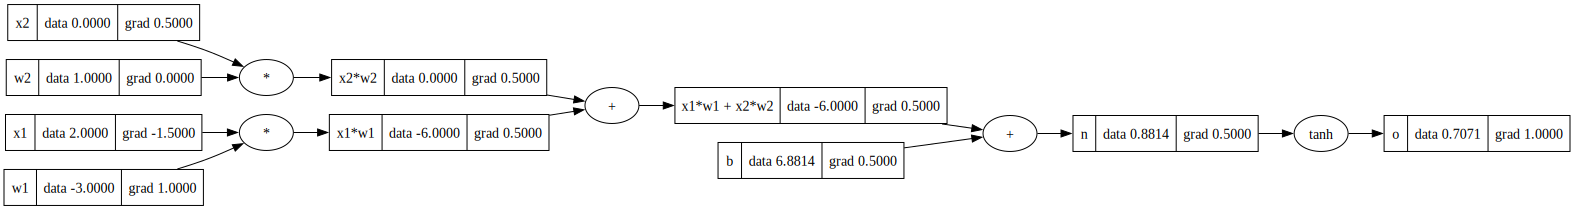

In [7]:
draw_dot(o)

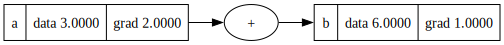

In [8]:
a=Value(3.0,label='a')
b=a+a ; b.label='b'
b.backward()
draw_dot(b)

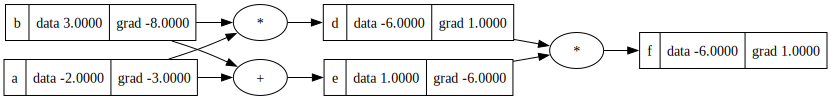

In [9]:
# Contoh lain
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [11]:
#Tiny dataset
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
n=MLP(3,[4,4,1])
ypred= [n(x) for x in xs] #Predicted output for each dataset input
ypred

[Value(data=-0.14041311549999214),
 Value(data=0.30733279834199195),
 Value(data=0.3363403376713684),
 Value(data=-0.3182037101537014)]

In [12]:
for k in range(20):
    #Forward pass
    ypred= [n(x) for x in xs] #Predicted output for each dataset input
    loss= sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
    # print(f'Loss: {loss.data}') #Value object juga
    # Dont forget to reset the gradient to zero (tadi kelupaan), kalo ga direset malah akumuluasi
    for p in n.parameters():
        p.grad=0.0
    #Backward pass
    loss.backward()
    #Update the parameters
    for p in n.parameters():
        p.data += -0.05*p.grad #Gradient descent, walk to the opposite direction of the gradient, 0.01 is a learning rate
    # print('---')
    print(k,loss.data)

0 6.533127639175713
1 4.339480599441646
2 3.881411887487943
3 3.425075007171179
4 3.28794682313257
5 3.035185170891122
6 2.6933411327007044
7 2.6392564813736152
8 2.4773086187580478
9 2.3558810548174263
10 1.8856764659489857
11 1.3643043734103748
12 2.704604378585839
13 1.4408973962156966
14 0.7392786619428979
15 0.3773424208178276
16 0.2682689777891145
17 0.21193954706190113
18 0.16835771572147537
19 0.1391851969656386


In [13]:
ypred= [n(x) for x in xs] #Predicted output for each dataset input
ypred

[Value(data=0.8138128392285779),
 Value(data=-0.9623060634186313),
 Value(data=-0.7393658116982055),
 Value(data=0.8759782221277801)]

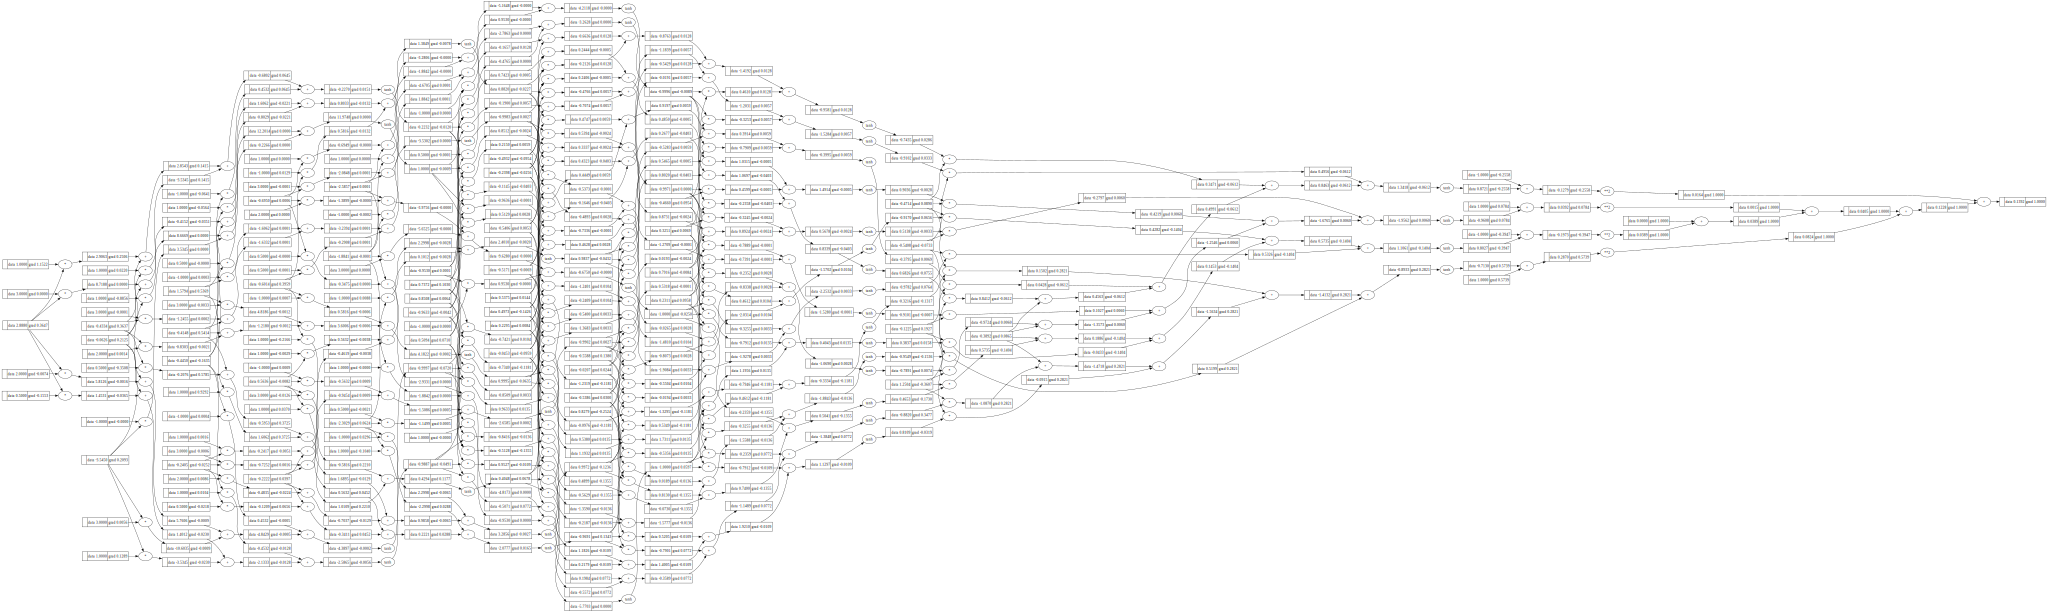

In [14]:
draw_dot(loss)